# model parameters size

In [ ]:
from pathlib import Path

import torch
import torch.nn as nn

# Set this to the base directory that contains all your run folders
# Example:
# base_dir = Path(r"C:\Users\niels\Projects\Thesis-Code\Saved models\20251128-171141_selective_positional_encoding")
# base_dir = Path(r"C:\Users\niels\Projects\Thesis-Code\Saved models\20251128-171141_selective_positional_encoding")
# base_dir = Path(r"C:\Users\niels\Projects\Thesis-Code\Saved models\20251126-150519_compare_positional_encodings")
base_dir = Path(r"C:\Users\niels\Projects\Thesis-Code\Saved models\20251127-162910_4t_vs_background_postional")

def _count_tensors_recursive(obj) -> int:
    """Recursively count number of elements in all tensors in a nested structure."""
    if torch.is_tensor(obj):
        return obj.numel()
    if isinstance(obj, dict):
        return sum(_count_tensors_recursive(v) for v in obj.values())
    if isinstance(obj, list | tuple):
        return sum(_count_tensors_recursive(v) for v in obj)
    return 0


def count_params_in_object(obj):
    """Return (total, trainable, non_trainable) parameter counts for a loaded object.

    - If it's an nn.Module (or inside a dict under 'model'), we use .parameters().
    - Otherwise we treat it as a (possibly nested) state_dict and count all tensor elements.
    """
    # Case 1: full model saved
    if isinstance(obj, nn.Module):
        total = sum(p.numel() for p in obj.parameters())
        trainable = sum(p.numel() for p in obj.parameters() if p.requires_grad)
        return total, trainable, total - trainable

    # Case 2: checkpoint dict with a 'model' key that is an nn.Module
    if isinstance(obj, dict) and isinstance(obj.get("model"), nn.Module):
        model = obj["model"]
        total = sum(p.numel() for p in model.parameters())
        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        return total, trainable, total - trainable

    # Case 3: nested state_dict / generic checkpoint (dict / list / tuple of tensors)
    if isinstance(obj, dict | list | tuple):
        total = _count_tensors_recursive(obj)
        if total > 0:
            # We cannot distinguish trainable vs non-trainable here
            return total, None, None

    return None, None, None


def scan_models_and_print_stats(base_dir: Path):
    if not base_dir.exists():
        print(f"Base directory does not exist: {base_dir}")
        return

    model_paths = sorted(base_dir.rglob("*.pt"))

    if not model_paths:
        print(f"No .pt models found under {base_dir}")
        return

    print(f"Found {len(model_paths)} .pt file(s) under {base_dir}\n")

    # Tabular header
    header = f"{'Run':40} {'File':20} {'Total params':15} {'Trainable':15} {'Non-trainable':15} Note"
    print(header)
    print("-" * len(header))

    for model_path in model_paths:
        run_dir = model_path.parent

        try:
            obj = torch.load(model_path, map_location="cpu")
            total, trainable, non_trainable = count_params_in_object(obj)
        except Exception as e:
            note = f"error loading: {e}".replace("\n", " ")
            print(f"{run_dir.name[-5:]:40} {model_path.name:20} {'-':15} {'-':15} {'-':15} {note}")
            continue

        if total is None:
            note = "unrecognized checkpoint format"
            print(f"{run_dir.name:40} {model_path.name:20} {'-':15} {'-':15} {'-':15} {note}")
            continue

        note = ""
        if trainable is None:
            note = "state_dict-style (no split)"

        total_str = f"{total:,}"
        trainable_str = f"{trainable:,}" if trainable is not None else "n/a"
        non_trainable_str = f"{non_trainable:,}" if non_trainable is not None else "n/a"

        print(
            f"{run_dir.name[-5:]:40} {model_path.name:20} "
            f"{total_str:15} {trainable_str:15} {non_trainable_str:15} {note}"
        )


# Run the scan. Edit `base_dir` above to point to a different multirun folder if needed.
scan_models_and_print_stats(base_dir)

Found 12 .pt file(s) under C:\Users\niels\Projects\Thesis-Code\Saved models\20251127-162910_4t_vs_background_postional

Run                                      File                 Total params    Trainable       Non-trainable   Note
------------------------------------------------------------------------------------------------------------------
_job0                                    best_val.pt          14,221,907      n/a             n/a             state_dict-style (no split)
_job0                                    last.pt              14,221,907      n/a             n/a             state_dict-style (no split)
_job0                                    model.pt             14,221,907      n/a             n/a             state_dict-style (no split)
_job1                                    best_val.pt          14,221,907      n/a             n/a             state_dict-style (no split)
_job1                                    last.pt              14,221,907      n/a             n/a 

C:\Users\niels\AppData\Local\Temp\ipykernel_35920\153556840.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(model_path, map_location="cpu")


# 🎯 Understanding the Inference Pipeline

This notebook walks through the inference phase step-by-step:
1. **Loading a trained model** from a run
2. **Getting data** (batches from dataloader)
3. **Running inference** (forward pass through the model)
4. **Computing metrics** (accuracy, AUROC, confusion matrix, etc.)
5. **Creating plots** (ROC curves, confusion matrices, score distributions)

Let's explore how classification inference works! 🚀


In [2]:
# Imports
from pathlib import Path

from omegaconf import OmegaConf

from thesis_ml.reports.inference.classification import run_classification_inference
from thesis_ml.reports.inference.classification_metrics import compute_classification_metrics
from thesis_ml.reports.plots.classification import (
    plot_confusion_matrix,
    plot_metrics_comparison,
    plot_roc_curves,
    plot_score_distributions,
)

# Inference utilities

print("✅ All imports loaded!")


✅ All imports loaded!


## Step 1: Load a Trained Model 🎨

First, we need to load a trained classifier model from a run. The `load_model_from_run` function:
- Finds the run directory
- Loads the config (from `.hydra/config.yaml` or `cfg.yaml`)
- Builds the model architecture
- Loads the trained weights (from `best_val.pt` or `model.pt`)
- Puts the model in eval mode

Let's pick a run and load it!


In [3]:
# Configuration
# Get repo root - handle both cases: running from repo root or from notebooks/
cwd = Path.cwd()
repo_root = cwd.parent if cwd.name == "notebooks" else cwd

output_root = repo_root / "outputs"
print(f"📁 Current directory: {cwd.absolute()}")
print(f"📁 Using output_root: {output_root.absolute()}")

# Verify the path exists
if not output_root.exists():
    raise FileNotFoundError(f"Output directory not found: {output_root.absolute()}\n"
                          f"Make sure you're running from the repo root or notebooks/ directory")

# Pick a classifier run (one with best_val.pt)
# You can change this to any classifier run ID you have
run_id = "run_20251113-113008_run"  # Change this to your run!

# Debug: Check if the run directory and config file exist
run_dir = output_root / "runs" / run_id
hydra_config = run_dir / ".hydra" / "config.yaml"
cfg_yaml = run_dir / "cfg.yaml"

print("\n🔍 Debugging paths:")
print(f"   Run directory: {run_dir.absolute()}")
print(f"   Run directory exists: {run_dir.exists()}")
print(f"   .hydra/config.yaml: {hydra_config.absolute()}")
print(f"   .hydra/config.yaml exists: {hydra_config.exists()}")
print(f"   cfg.yaml: {cfg_yaml.absolute()}")
print(f"   cfg.yaml exists: {cfg_yaml.exists()}")

# Load the model
print(f"\n📦 Loading model from run: {run_id}")

# First, load the config manually so we can override the data path
from thesis_ml.utils.paths import resolve_run_dir  # noqa: E402

run_dir = resolve_run_dir(run_id, output_root)
hydra_cfg_path = run_dir / ".hydra" / "config.yaml"
if hydra_cfg_path.exists():
    cfg = OmegaConf.load(str(hydra_cfg_path))
else:
    cfg_path = run_dir / "cfg.yaml"
    if not cfg_path.exists():
        raise FileNotFoundError(f"Missing .hydra/config.yaml or cfg.yaml in {run_dir}")
    cfg = OmegaConf.load(str(cfg_path))

# Override data path to use local file
local_data_path = Path("C:/Users/niels/Projects/Thesis-Code/Data/4tops_splitted.h5")
if local_data_path.exists():
    print(f"📁 Overriding data path to use local file: {local_data_path}")
    # Override the data path - it's stored as ${env.data_root}/4tops_splitted.h5
    # We can either override env.data_root or directly set data.path
    cfg.data.path = str(local_data_path)
    # Also update env.data_root for consistency
    if hasattr(cfg, "env"):
        cfg.env.data_root = str(local_data_path.parent)
    print(f"   Updated data.path: {cfg.data.path}")
else:
    print(f"⚠️  Local data file not found at {local_data_path}")
    print(f"   Using original path: {cfg.data.get('path', 'N/A')}")

# Now load the model with the updated config
from thesis_ml.architectures.transformer_classifier.base import build_from_config  # noqa: E402
from thesis_ml.data.h5_loader import make_classification_dataloaders  # noqa: E402
from thesis_ml.training_loops.transformer_classifier import _gather_meta  # noqa: E402

# Resolve device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Populate meta if missing (needed for model building)
if not hasattr(cfg, "meta") or cfg.meta is None:
    # Create dataloaders temporarily to get meta
    train_dl, val_dl, test_dl, meta = make_classification_dataloaders(cfg)
    _gather_meta(cfg, meta)

model = build_from_config(cfg, cfg.meta).to(device)

# Load weights
best_val_path = run_dir / "best_val.pt"
model_pt_path = run_dir / "model.pt"
if best_val_path.exists():
    weights_path = best_val_path
elif model_pt_path.exists():
    weights_path = model_pt_path
else:
    raise FileNotFoundError(f"Missing best_val.pt or model.pt in {run_dir}")

checkpoint = torch.load(str(weights_path), map_location=device, weights_only=False)
state_dict = checkpoint["model_state_dict"] if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint else checkpoint
model.load_state_dict(state_dict)
model.eval()

print("✅ Model loaded!")
print(f"   Device: {device}")
print(f"   Model type: {type(model).__name__}")
print(f"   Model in eval mode: {not model.training}")
# Count model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print("\n📊 Model Parameters:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Non-trainable parameters: {non_trainable_params:,}")

# Check if it's a classifier
if hasattr(cfg, "classifier"):
    print("   ✅ This is a classifier model!")
    if hasattr(cfg, "meta") and hasattr(cfg.meta, "n_classes"):
        print(f"   Number of classes: {cfg.meta.n_classes}")
else:
    print("   ⚠️  This might be an autoencoder, not a classifier")


📁 Current directory: c:\Users\niels\Projects\Thesis-Code\Code\Niels_repo\notebooks
📁 Using output_root: c:\Users\niels\Projects\Thesis-Code\Code\Niels_repo\outputs

🔍 Debugging paths:
   Run directory: c:\Users\niels\Projects\Thesis-Code\Code\Niels_repo\outputs\runs\run_20251113-113008_run
   Run directory exists: True
   .hydra/config.yaml: c:\Users\niels\Projects\Thesis-Code\Code\Niels_repo\outputs\runs\run_20251113-113008_run\.hydra\config.yaml
   .hydra/config.yaml exists: True
   cfg.yaml: c:\Users\niels\Projects\Thesis-Code\Code\Niels_repo\outputs\runs\run_20251113-113008_run\cfg.yaml
   cfg.yaml exists: False

📦 Loading model from run: run_20251113-113008_run
📁 Overriding data path to use local file: C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5
   Updated data.path: C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5
✅ Model loaded!
   Device: cuda
   Model type: TransformerClassifier
   Model in eval mode: True

📊 Model Parameters:
   Total parameters: 794,

## Step 2: Get a Batch of Data 📊

Now let's get a single batch from the validation set to see what the data looks like. The batch format depends on whether we're using:
- **Raw format**: `(tokens_cont, tokens_id, globals, mask, label)` - 5 items
- **Binned format**: `(integer_tokens, globals_ints, mask, label)` - 4 items

Let's peek at one batch!


In [4]:
# Get a single batch from validation set
# Note: For classification, we need to use make_classification_dataloaders, not get_example_batch
print("📊 Getting a batch from validation set...")
from thesis_ml.data.h5_loader import make_classification_dataloaders  # noqa: E402

train_dl, val_dl, test_dl, _meta = make_classification_dataloaders(cfg)
batch = next(iter(val_dl))

print("✅ Batch retrieved!")
print(f"   Batch type: {type(batch)}")
print(f"   Number of items in batch: {len(batch)}")

# Unpack based on format
if len(batch) == 5:
    tokens_cont, tokens_id, globals, mask, label = batch
    print("   Format: Raw (5 items)")
    print(f"   tokens_cont shape: {tokens_cont.shape}")  # [B, T, 4]
    print(f"   tokens_id shape: {tokens_id.shape}")     # [B, T]
    print(f"   globals shape: {globals.shape}")          # [B, G]
    print(f"   mask shape: {mask.shape}")                # [B, T]
    print(f"   label shape: {label.shape}")             # [B]
elif len(batch) == 4:
    integer_tokens, globals_ints, mask, label = batch
    print("   Format: Binned (4 items)")
    print(f"   integer_tokens shape: {integer_tokens.shape}")  # [B, T]
    print(f"   globals_ints shape: {globals_ints.shape}")     # [B, G]
    print(f"   mask shape: {mask.shape}")                     # [B, T]
    print(f"   label shape: {label.shape}")                   # [B]
else:
    raise ValueError(f"Unexpected batch format with {len(batch)} items")

# Print label info
print(f"\n   Label values (first 10): {label[:10].tolist()}")
print(f"   Unique labels: {torch.unique(label).tolist()}")


📊 Getting a batch from validation set...
✅ Batch retrieved!
   Batch type: <class 'list'>
   Number of items in batch: 5
   Format: Raw (5 items)
   tokens_cont shape: torch.Size([64, 18, 4])
   tokens_id shape: torch.Size([64, 18])
   globals shape: torch.Size([64, 2])
   mask shape: torch.Size([64, 18])
   label shape: torch.Size([64])

   Label values (first 10): [1, 0, 1, 1, 1, 0, 0, 0, 0, 1]
   Unique labels: [0, 1]


## Step 3: Run Inference on a Single Batch 🔮

Now let's do a forward pass through the model! This is the core of inference:
1. Move batch to device (GPU/CPU)
2. Run model forward pass (with `torch.no_grad()` for efficiency)
3. Get logits (raw model outputs)
4. Convert to probabilities using softmax
5. Get predictions (argmax of probabilities)

Let's see it in action!


In [5]:
# Move model to device and set to eval mode
model.eval()
model.to(device)

# Run inference on the batch
print("🔮 Running inference on batch...")
with torch.no_grad():
    # Move batch to device
    if len(batch) == 5:
        tokens_cont, tokens_id, globals, mask, label = batch
        tokens_cont = tokens_cont.to(device)
        tokens_id = tokens_id.to(device)
        mask = mask.to(device)
        label = label.to(device)
        
        # Forward pass
        logits = model(tokens_cont, tokens_id, mask=mask)
    else:  # binned format
        integer_tokens, globals_ints, mask, label = batch
        integer_tokens = integer_tokens.to(device)
        mask = mask.to(device)
        label = label.to(device)
        
        # Forward pass
        logits = model(integer_tokens, mask=mask)

print("✅ Forward pass complete!")
print(f"   Logits shape: {logits.shape}")  # [B, n_classes]

# Convert to probabilities
probs = torch.softmax(logits, dim=-1)
print(f"   Probabilities shape: {probs.shape}")  # [B, n_classes]
print(f"   Probabilities sum to 1: {torch.allclose(probs.sum(dim=-1), torch.ones(probs.shape[0], device=device))}")

# Get predictions
preds = probs.argmax(dim=-1)
print(f"   Predictions shape: {preds.shape}")  # [B]

# Show some examples
print("\n   First 5 examples:")
for i in range(min(5, len(label))):
    true_label = label[i].item()
    pred_label = preds[i].item()
    confidence = probs[i, pred_label].item()
    print(f"     Example {i}: True={true_label}, Pred={pred_label}, Confidence={confidence:.3f}")


🔮 Running inference on batch...
✅ Forward pass complete!
   Logits shape: torch.Size([64, 2])
   Probabilities shape: torch.Size([64, 2])
   Probabilities sum to 1: True
   Predictions shape: torch.Size([64])

   First 5 examples:
     Example 0: True=1, Pred=1, Confidence=0.521
     Example 1: True=0, Pred=0, Confidence=0.974
     Example 2: True=1, Pred=1, Confidence=0.935
     Example 3: True=1, Pred=1, Confidence=0.944
     Example 4: True=1, Pred=0, Confidence=0.836


## Step 4: Run Full Inference on Dataset 🎯

Now let's run inference on the entire validation set! This is what `run_classification_inference` does:
1. Creates a dataloader for the specified split
2. Iterates through all batches
3. Accumulates logits, labels, and probabilities
4. Computes comprehensive metrics

Let's do it!


In [6]:
# Prepare model in the format expected by run_classification_inference
# It expects: list of (run_id, cfg, model) tuples
models = [(run_id, cfg, model)]

# Run inference on validation set (with limited samples for speed)
print("🎯 Running full inference on validation set...")
print("   (Using max_samples=1000 for speed - remove this in production!)")

inference_results = run_classification_inference(
    models=models,
    dataset_cfg=cfg,
    split="val",
    inference_cfg={
        "batch_size": 512,
        "autocast": False,
        "seed": 42,
        "max_samples": 1000,  # Limit for demo - remove in production!
    },
)

print("\n✅ Inference complete!")
print(f"   Results keys: {list(inference_results.keys())}")

# Show metrics for our run
if run_id in inference_results:
    metrics = inference_results[run_id]
    print(f"\n📊 Metrics for {run_id}:")
    print(f"   Accuracy: {metrics.get('accuracy', 0):.4f}")
    print(f"   AUROC: {metrics.get('auroc', 'N/A')}")
    print(f"   Precision (macro): {metrics.get('precision_macro', 0):.4f}")
    print(f"   Recall (macro): {metrics.get('recall_macro', 0):.4f}")
    print(f"   F1 (macro): {metrics.get('f1_macro', 0):.4f}")
    
    # Confusion matrix
    cm = metrics.get('confusion_matrix', [])
    if cm:
        print("\n   Confusion Matrix:")
        for _i, row in enumerate(cm):
            print(f"     {row}")


🎯 Running full inference on validation set...
   (Using max_samples=1000 for speed - remove this in production!)

✅ Inference complete!
   Results keys: ['run_20251113-113008_run']

📊 Metrics for run_20251113-113008_run:
   Accuracy: 0.8428
   AUROC: 0.8617259571458045
   Precision (macro): 0.7565
   Recall (macro): 0.7476
   F1 (macro): 0.7518

   Confusion Matrix:
     [470, 48]
     [54, 77]


## Step 5: Understanding the Metrics Computation 📈

Let's manually compute metrics on a small batch to see how it works! The `compute_classification_metrics` function:
1. Concatenates all batches
2. Computes predictions (argmax of probabilities)
3. Calculates accuracy, precision, recall, F1
4. Computes AUROC (for binary or multi-class)
5. Builds confusion matrix
6. Computes ROC and PR curves

Let's peek under the hood!


In [7]:
# Let's manually compute metrics on a few batches to understand the process
from thesis_ml.data.h5_loader import make_classification_dataloaders

# Create a small dataloader
temp_cfg = OmegaConf.create(OmegaConf.to_container(cfg, resolve=True))
if hasattr(temp_cfg, "data"):
    temp_cfg.data.limit_samples = 100  # Just 100 samples for demo
train_dl, val_dl, test_dl, meta = make_classification_dataloaders(temp_cfg)

print("📈 Computing metrics manually on a few batches...")
model.eval()
model.to(device)

all_logits = []
all_labels = []
all_probs = []

# Process first 3 batches
with torch.no_grad():
    for batch_idx, batch in enumerate(val_dl):
        if batch_idx >= 3:  # Just 3 batches for demo
            break
            
        # Unpack and move to device
        if len(batch) == 5:
            tokens_cont, tokens_id, globals, mask, label = batch
            tokens_cont = tokens_cont.to(device)
            tokens_id = tokens_id.to(device)
            mask = mask.to(device)
            label = label.to(device)
            logits = model(tokens_cont, tokens_id, mask=mask)
        else:
            integer_tokens, globals_ints, mask, label = batch
            integer_tokens = integer_tokens.to(device)
            mask = mask.to(device)
            label = label.to(device)
            logits = model(integer_tokens, mask=mask)
        
        probs = torch.softmax(logits, dim=-1)
        
        # Accumulate (move to CPU to save GPU memory)
        all_logits.append(logits.cpu())
        all_labels.append(label.cpu())
        all_probs.append(probs.cpu())
        
        print(f"   Batch {batch_idx + 1}: {logits.shape[0]} samples")

# Get n_classes
n_classes = cfg.meta.n_classes if hasattr(cfg, "meta") and hasattr(cfg.meta, "n_classes") else meta.get("n_classes", 2)

# Now compute metrics
print(f"\n🔢 Computing metrics (n_classes={n_classes})...")
metrics = compute_classification_metrics(all_logits, all_labels, all_probs, n_classes)

print("\n✅ Metrics computed!")
print(f"   Accuracy: {metrics['accuracy']:.4f}")
print(f"   AUROC: {metrics.get('auroc', 'N/A')}")
print(f"   Precision per class: {metrics['precision_per_class']}")
print(f"   Recall per class: {metrics['recall_per_class']}")
print(f"   F1 per class: {metrics['f1_per_class']}")
print(f"   Support per class: {metrics['support_per_class']}")


📈 Computing metrics manually on a few batches...
   Batch 1: 64 samples
   Batch 2: 6 samples

🔢 Computing metrics (n_classes=2)...

✅ Metrics computed!
   Accuracy: 0.8000
   AUROC: 0.844017094017094
   Precision per class: [0.8166666666666667, 0.7]
   Recall per class: [0.9423076923076923, 0.3888888888888889]
   F1 per class: [0.875, 0.5]
   Support per class: [52, 18]


## Step 6: Creating Plots 🎨

Now let's create the beautiful plots! The plotting functions take the inference results and create:
1. **ROC Curves**: Shows true positive rate vs false positive rate
2. **Confusion Matrix**: Shows prediction vs true label matrix
3. **Metrics Comparison**: Bar chart comparing metrics across models
4. **Score Distributions**: Histogram of classifier scores for signal vs background

Let's generate them!


🎨 Creating plots...
   1. Plotting ROC curves...
      ⚠️  Error: [Errno 2] No such file or directory: 'C:\\Users\\niels\\Projects\\Thesis-Code\\Code\\Niels_repo\\notebooks\\notebooks\\temp_figures\\figure-roc_curves.png'
   2. Plotting confusion matrix...
      ⚠️  Error: [Errno 2] No such file or directory: 'C:\\Users\\niels\\Projects\\Thesis-Code\\Code\\Niels_repo\\notebooks\\notebooks\\temp_figures\\figure-confusion_matrices_run_20251113-113008_run.png'
   3. Plotting metrics comparison...
      ⚠️  Error: [Errno 2] No such file or directory: 'C:\\Users\\niels\\Projects\\Thesis-Code\\Code\\Niels_repo\\notebooks\\notebooks\\temp_figures\\figure-metrics_comparison.png'
   4. Plotting score distributions...
      ⚠️  Error: [Errno 2] No such file or directory: 'C:\\Users\\niels\\Projects\\Thesis-Code\\Code\\Niels_repo\\notebooks\\notebooks\\temp_figures\\figure-score_distributions_run_20251113-113008_run.png'

✅ All plots saved to: notebooks\temp_figures
   Files:


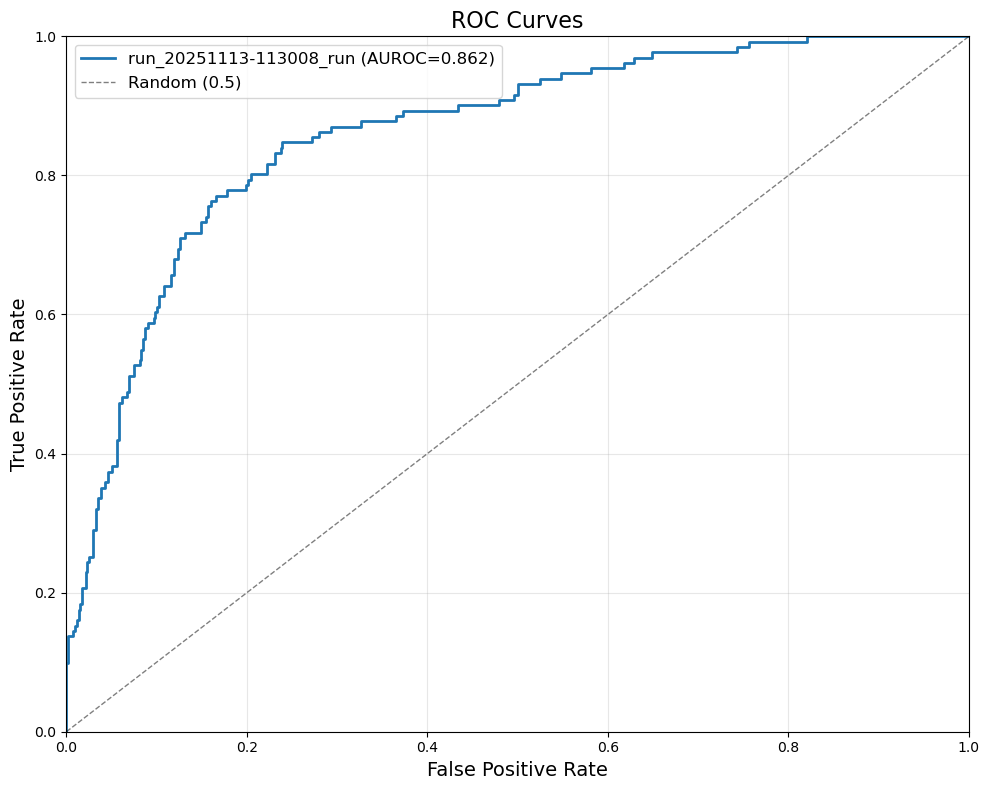

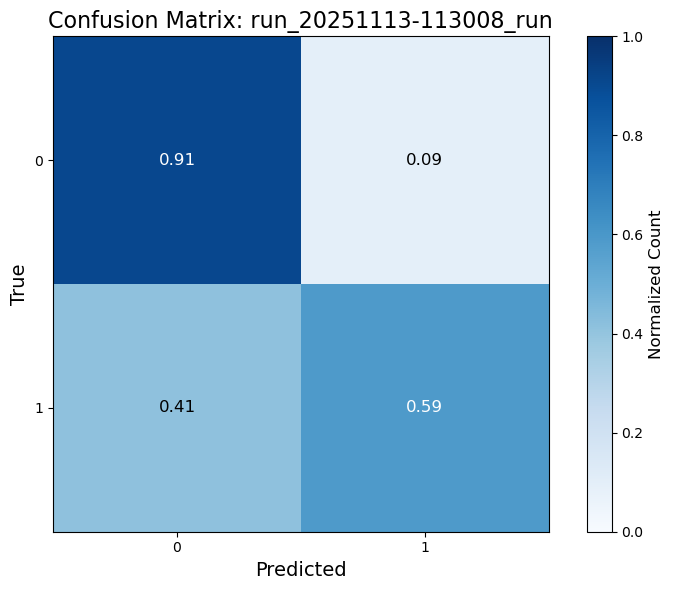

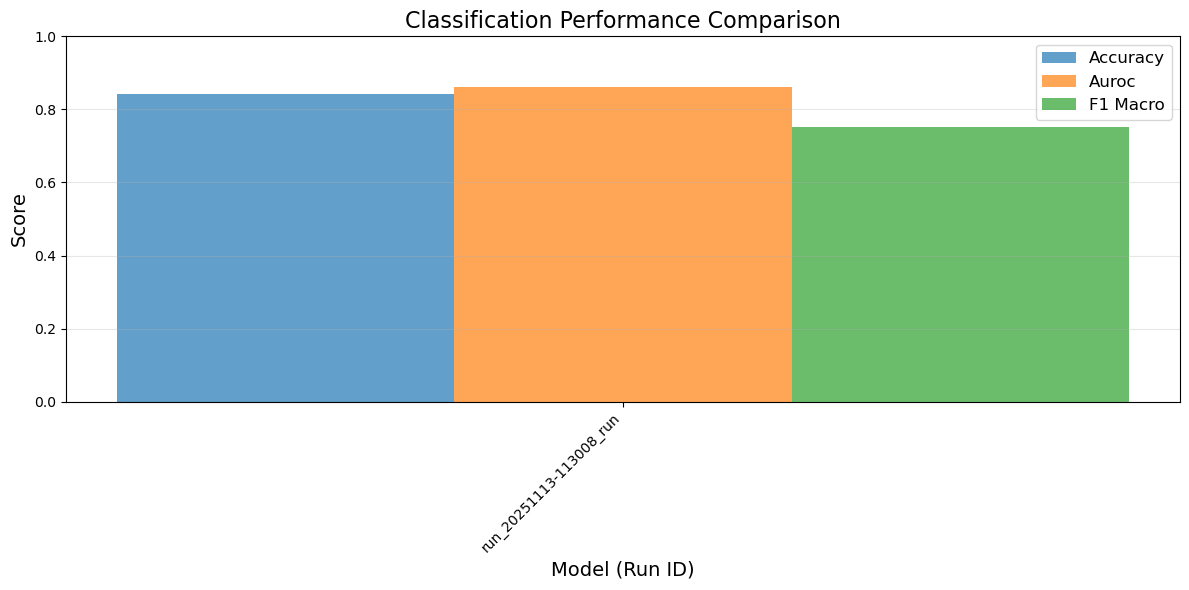

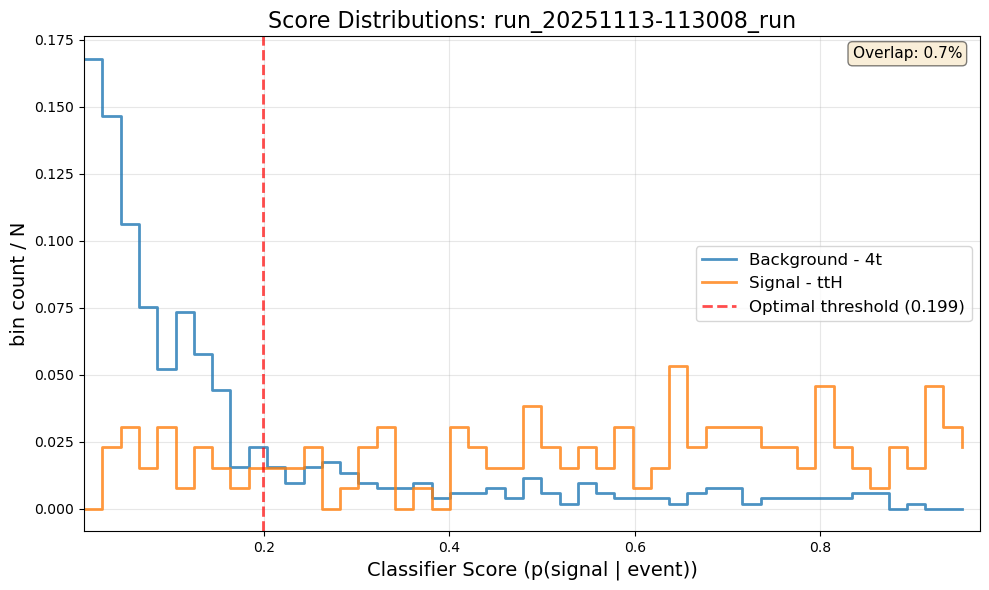

In [8]:
# Create a temporary directory for figures
figs_dir = Path("notebooks/temp_figures")
# figs_dir.mkdir(exist_ok=True)

# Figure config (format and DPI)
fig_cfg = {"fig_format": "png", "dpi": 150}

print("🎨 Creating plots...")

# 1. ROC Curves
print("   1. Plotting ROC curves...")
try:
    plot_roc_curves(inference_results, figs_dir, fig_cfg)
    print("      ✅ ROC curves saved!")
except Exception as e:
    print(f"      ⚠️  Error: {e}")

# 2. Confusion Matrix
print("   2. Plotting confusion matrix...")
try:
    plot_confusion_matrix(inference_results, figs_dir, fig_cfg)
    print("      ✅ Confusion matrix saved!")
except Exception as e:
    print(f"      ⚠️  Error: {e}")

# 3. Metrics Comparison
print("   3. Plotting metrics comparison...")
try:
    plot_metrics_comparison(inference_results, figs_dir, fig_cfg)
    print("      ✅ Metrics comparison saved!")
except Exception as e:
    print(f"      ⚠️  Error: {e}")

# 4. Score Distributions (only for binary classification)
print("   4. Plotting score distributions...")
try:
    plot_score_distributions(inference_results, figs_dir, fig_cfg)
    print("      ✅ Score distributions saved!")
except Exception as e:
    print(f"      ⚠️  Error: {e}")

print(f"\n✅ All plots saved to: {figs_dir}")
print("   Files:")
for f in sorted(figs_dir.glob("*.png")):
    print(f"     - {f.name}")


## Step 7: Visualize the Plots 📊

Let's display the plots we just created!


In [9]:
# Display the plots
from IPython.display import Image, display

figs_dir = Path("notebooks/temp_figures")

# Find all PNG files
png_files = sorted(figs_dir.glob("*.png"))

if png_files:
    print(f"📊 Found {len(png_files)} plot(s):\n")
    for png_file in png_files:
        print(f"   {png_file.name}")
        display(Image(str(png_file), width=800))
        print()
else:
    print("⚠️  No plots found. Make sure Step 6 ran successfully!")


⚠️  No plots found. Make sure Step 6 ran successfully!


## Summary: The Inference Pipeline 🎓

Here's what we learned about the inference pipeline:

### 1. **Model Loading** (`load_model_from_run`)
   - Finds run directory and loads config
   - Builds model architecture from config
   - Loads trained weights
   - Sets model to eval mode

### 2. **Data Loading** (`get_example_batch` / `make_classification_dataloaders`)
   - Creates dataloader for specified split (train/val/test)
   - Returns batches in either raw (5 items) or binned (4 items) format
   - Each batch contains: tokens, masks, labels

### 3. **Forward Pass** (model inference)
   - Move batch to device (GPU/CPU)
   - Run model forward pass with `torch.no_grad()`
   - Get logits (raw outputs)
   - Convert to probabilities with softmax
   - Get predictions with argmax

### 4. **Metrics Computation** (`compute_classification_metrics`)
   - Concatenates all batches
   - Computes accuracy, precision, recall, F1
   - Calculates AUROC (binary or multi-class)
   - Builds confusion matrix
   - Computes ROC and PR curves

### 5. **Plotting** (classification plotting functions)
   - **ROC Curves**: TPR vs FPR for different models
   - **Confusion Matrix**: Prediction vs true label heatmap
   - **Metrics Comparison**: Bar chart of key metrics
   - **Score Distributions**: Histogram of classifier scores

### The Full Pipeline (`run_classification_inference`)
   - Orchestrates all steps above
   - Processes multiple models
   - Handles batching, device management, autocast
   - Returns nested dict: `{run_id: {metrics...}}`

### Key Takeaways:
- Inference is done in **eval mode** (`model.eval()`)
- Use `torch.no_grad()` to save memory and speed
- Metrics are computed on **all batches** concatenated
- Plots are generated from the metrics dictionary
- The pipeline supports both **binary** and **multi-class** classification

🎉 You now understand how inference works!


In [10]:
# Optional: Clean up temporary figures directory
# Uncomment to delete the temp figures after viewing
# import shutil
# if figs_dir.exists():
#     shutil.rmtree(figs_dir)
#     print("🧹 Cleaned up temporary figures directory")
